In [4]:
from datetime import datetime
today = datetime.today().date()
formatted_date = today.strftime('%Y%m%d')
print("今天的日期是:", formatted_date)

今天的日期是: 20240531


In [7]:
import pandas as pd
df = pd.read_csv('scraping_data/0531_no_label_data.csv')
nasdaq_tickers = pd.read_csv('nasdaq_tickers.csv')
filtered_df = df[df['stock_symbol'].isin(nasdaq_tickers['Ticker'])]
filtered_df = filtered_df.reset_index(drop=True)
filtered_df

,stock_symbol,title,date,paragraphs
0,COST,Costco Wholesale (COST) Q3 2024 Earnings Call ...,2024-05-30,rator\n\nThank you for standing by. My name is...
1,MRVL,Marvell Technology (MRVL) Q1 2025 Earnings Cal...,2024-05-30,"perator\n\nGood afternoon, and welcome to Marv..."
2,DLTH,Duluth (DLTH) Q1 2024 Earnings Call Transcript,2024-05-30,"od morning, everyone, and welcome to the Dulut..."
3,CGC,Canopy Growth (CGC) Q4 2024 Earnings Call Tran...,2024-05-30,"or\n\nGood morning. My name is Joanna, and I w..."
4,NCNO,nCino (NCNO) Q1 2025 Earnings Call Transcript,2024-05-29,d day and thank you for standing by. Welcome t...
...,...,...,...,...
2869,CNDT,Conduent Incorporated (CNDT) Q4 2021 Earnings ...,2022-02-16,\n\nOperator\n\nGreetings. Welcome to the Cond...
2870,AXTI,AXT (AXTI) Q4 2021 Earnings Call Transcript,2022-02-16,"fternoon, everyone, and welcome to AXT's fourt..."
2871,BCOV,Brightcove (BCOV) Q4 2021 Earnings Call Transc...,2022-02-16,tings. Welcome to the Brightcove fourth quarte...
2872,APP,AppLovin Corporation (APP) Q4 2021 Earnings Ca...,2022-02-16,\nOperator\n\nGreetings. Welcome to AppLovin C...


In [9]:
%%time
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

# 設定 DataFrame 的欄位名稱
columns = ['stock_symbol', 'title', 'date', 'paragraphs'
           '0_day_close', '1_day_close', '2_day_close', '3_day_close', 
           '4_day_close', '5_day_close', '7_day_close', '14_day_close', 
           '1_month_close', '2_month_close']

# 初始化新的 DataFrame
new_df = pd.DataFrame(columns=columns)

# 自定義函數來抓取股價資料並計算指定日期的收盤價
def get_close_prices(ticker, date):
    stock = yf.Ticker(ticker)
    hist = stock.history(start=date, end=(datetime.strptime(date, "%Y-%m-%d") + timedelta(days=60)).strftime("%Y-%m-%d"))
    
    close_prices = {}
    if date in hist.index:
        close_prices['0_day_close'] = hist.loc[date]['Close']
        # 檢查每個日期是否存在於資料中，否則返回 None
        close_prices['1_day_close'] = hist.loc[hist.index[hist.index.get_loc(date) + 1]]['Close'] if (hist.index.get_loc(date) + 1) < len(hist.index) else None
        close_prices['2_day_close'] = hist.loc[hist.index[hist.index.get_loc(date) + 2]]['Close'] if (hist.index.get_loc(date) + 2) < len(hist.index) else None
        close_prices['3_day_close'] = hist.loc[hist.index[hist.index.get_loc(date) + 3]]['Close'] if (hist.index.get_loc(date) + 3) < len(hist.index) else None
        close_prices['4_day_close'] = hist.loc[hist.index[hist.index.get_loc(date) + 4]]['Close'] if (hist.index.get_loc(date) + 4) < len(hist.index) else None
        close_prices['5_day_close'] = hist.loc[hist.index[hist.index.get_loc(date) + 5]]['Close'] if (hist.index.get_loc(date) + 5) < len(hist.index) else None
        close_prices['7_day_close'] = hist.loc[hist.index[hist.index.get_loc(date) + 7]]['Close'] if (hist.index.get_loc(date) + 7) < len(hist.index) else None
        close_prices['14_day_close'] = hist.loc[hist.index[hist.index.get_loc(date) + 14]]['Close'] if (hist.index.get_loc(date) + 14) < len(hist.index) else None
        
        # 計算一個月和兩個月後的日期
        one_month_date = (datetime.strptime(date, "%Y-%m-%d") + timedelta(days=30)).strftime("%Y-%m-%d")
        two_month_date = (datetime.strptime(date, "%Y-%m-%d") + timedelta(days=60)).strftime("%Y-%m-%d")
        close_prices['1_month_close'] = hist.loc[one_month_date]['Close'] if one_month_date in hist.index else None
        close_prices['2_month_close'] = hist.loc[two_month_date]['Close'] if two_month_date in hist.index else None
    else:
        close_prices = {key: None for key in ['0_day_close', '1_day_close', '2_day_close', '3_day_close', 
                                               '4_day_close', '5_day_close', '7_day_close', '14_day_close', 
                                               '1_month_close', '2_month_close']}
    return close_prices

# 遍歷每一行並計算收盤價
for index, row in filtered_df.iterrows():
    date_str = row['date']
    ticker_symbol = row['stock_symbol']
    title = row['title']
    paragraphs = row['paragraphs']
    close_prices = get_close_prices(ticker_symbol, date_str)
    
    # 添加到新 DataFrame
    new_row = pd.DataFrame([{
        'stock_symbol': ticker_symbol,
        'title': title,
        'date': date_str,
        'paragraphs': paragraphs,
        **close_prices
    }])
    new_df = pd.concat([new_df, new_row], ignore_index=True)

# 顯示新 DataFrame
new_df

<timed exec>:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
<timed exec>:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
<timed exec>:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
<timed exec>:58: FutureWarning: The behavior of DataFrame concatena

CPU times: total: 16.8 s
Wall time: 6min 3s


,stock_symbol,title,date,paragraphs0_day_close,1_day_close,2_day_close,3_day_close,4_day_close,5_day_close,7_day_close,14_day_close,1_month_close,2_month_close,paragraphs,0_day_close
0,COST,Costco Wholesale (COST) Q3 2024 Earnings Call ...,2024-05-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,rator\n\nThank you for standing by. My name is...,815.340027
1,MRVL,Marvell Technology (MRVL) Q1 2025 Earnings Cal...,2024-05-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,"perator\n\nGood afternoon, and welcome to Marv...",76.849998
2,DLTH,Duluth (DLTH) Q1 2024 Earnings Call Transcript,2024-05-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,"od morning, everyone, and welcome to the Dulut...",3.960000
3,CGC,Canopy Growth (CGC) Q4 2024 Earnings Call Tran...,2024-05-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,"or\n\nGood morning. My name is Joanna, and I w...",8.590000
4,NCNO,nCino (NCNO) Q1 2025 Earnings Call Transcript,2024-05-29,NaN,30.110001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,d day and thank you for standing by. Welcome t...,30.150000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2869,CNDT,Conduent Incorporated (CNDT) Q4 2021 Earnings ...,2022-02-16,NaN,4.680000,4.780000,4.710000,5.100000,5.030000,4.870000,4.390000,4.720000,None,\n\nOperator\n\nGreetings. Welcome to the Cond...,4.730000
2870,AXTI,AXT (AXTI) Q4 2021 Earnings Call Transcript,2022-02-16,NaN,7.610000,7.450000,7.220000,6.870000,7.250000,7.450000,7.290000,7.250000,None,"fternoon, everyone, and welcome to AXT's fourt...",7.930000
2871,BCOV,Brightcove (BCOV) Q4 2021 Earnings Call Transc...,2022-02-16,NaN,7.780000,7.470000,7.210000,6.920000,7.130000,7.480000,7.370000,7.690000,None,tings. Welcome to the Brightcove fourth quarte...,9.040000
2872,APP,AppLovin Corporation (APP) Q4 2021 Earnings Ca...,2022-02-16,NaN,64.129997,63.770000,57.330002,56.279999,57.110001,58.080002,48.540001,54.450001,None,\nOperator\n\nGreetings. Welcome to AppLovin C...,68.709999


In [18]:
new_df = new_df.drop(columns=['paragraphs0_day_close'])

,stock_symbol,title,date,1_day_close,2_day_close,3_day_close,4_day_close,5_day_close,7_day_close,14_day_close,1_month_close,2_month_close,paragraphs,0_day_close
0,COST,Costco Wholesale (COST) Q3 2024 Earnings Call ...,2024-05-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,rator\n\nThank you for standing by. My name is...,815.340027
1,MRVL,Marvell Technology (MRVL) Q1 2025 Earnings Cal...,2024-05-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,"perator\n\nGood afternoon, and welcome to Marv...",76.849998
2,DLTH,Duluth (DLTH) Q1 2024 Earnings Call Transcript,2024-05-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,"od morning, everyone, and welcome to the Dulut...",3.960000
3,CGC,Canopy Growth (CGC) Q4 2024 Earnings Call Tran...,2024-05-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,"or\n\nGood morning. My name is Joanna, and I w...",8.590000
4,NCNO,nCino (NCNO) Q1 2025 Earnings Call Transcript,2024-05-29,30.110001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,d day and thank you for standing by. Welcome t...,30.150000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2869,CNDT,Conduent Incorporated (CNDT) Q4 2021 Earnings ...,2022-02-16,4.680000,4.780000,4.710000,5.100000,5.030000,4.870000,4.390000,4.720000,None,\n\nOperator\n\nGreetings. Welcome to the Cond...,4.730000
2870,AXTI,AXT (AXTI) Q4 2021 Earnings Call Transcript,2022-02-16,7.610000,7.450000,7.220000,6.870000,7.250000,7.450000,7.290000,7.250000,None,"fternoon, everyone, and welcome to AXT's fourt...",7.930000
2871,BCOV,Brightcove (BCOV) Q4 2021 Earnings Call Transc...,2022-02-16,7.780000,7.470000,7.210000,6.920000,7.130000,7.480000,7.370000,7.690000,None,tings. Welcome to the Brightcove fourth quarte...,9.040000
2872,APP,AppLovin Corporation (APP) Q4 2021 Earnings Ca...,2022-02-16,64.129997,63.770000,57.330002,56.279999,57.110001,58.080002,48.540001,54.450001,None,\nOperator\n\nGreetings. Welcome to AppLovin C...,68.709999


In [21]:
new_df.to_csv('scraping_data/' + formatted_date + 'nasdaq_price_volatility.csv', index=False)

In [25]:
cleaned_df = new_df.copy()
cleaned_df = cleaned_df.drop(columns=['2_day_close','3_day_close','4_day_close','5_day_close','7_day_close', '14_day_close','1_month_close','2_month_close'])
cleaned_df = cleaned_df.dropna(subset=['1_day_close'])
cleaned_df = cleaned_df.reset_index(drop=True)
cleaned_df

,stock_symbol,title,date,1_day_close,paragraphs,0_day_close
0,NCNO,nCino (NCNO) Q1 2025 Earnings Call Transcript,2024-05-29,30.110001,d day and thank you for standing by. Welcome t...,30.150000
1,OKTA,Okta (OKTA) Q1 2025 Earnings Call Transcript,2024-05-29,88.809998,"i\n\nHi, everyone. Welcome to Okta's first qua...",96.360001
2,SSYS,Stratasys (SSYS) Q1 2024 Earnings Call Transcript,2024-05-29,9.020000,"Greetings, and welcome to the Stratasys first ...",8.820000
3,NVDA,Nvidia (NVDA) Q1 2025 Earnings Call Transcript,2024-05-22,1037.989990,"od afternoon. My name is Regina, and I will be...",949.500000
4,BZUN,Baozun (BZUN) Q1 2024 Earnings Call Transcript,2024-05-28,2.720000,"d morning, ladies and gentlemen, and thank you...",2.660000
...,...,...,...,...,...,...
2864,CNDT,Conduent Incorporated (CNDT) Q4 2021 Earnings ...,2022-02-16,4.680000,\n\nOperator\n\nGreetings. Welcome to the Cond...,4.730000
2865,AXTI,AXT (AXTI) Q4 2021 Earnings Call Transcript,2022-02-16,7.610000,"fternoon, everyone, and welcome to AXT's fourt...",7.930000
2866,BCOV,Brightcove (BCOV) Q4 2021 Earnings Call Transc...,2022-02-16,7.780000,tings. Welcome to the Brightcove fourth quarte...,9.040000
2867,APP,AppLovin Corporation (APP) Q4 2021 Earnings Ca...,2022-02-16,64.129997,\nOperator\n\nGreetings. Welcome to AppLovin C...,68.709999


In [26]:
# 新增 後一天change rate
cleaned_df['1_day_change_rate'] = (cleaned_df['1_day_close'] - cleaned_df['0_day_close']) / cleaned_df['0_day_close']

# add label
cleaned_df['1_day_change_binary_label'] = cleaned_df['1_day_change_rate'].apply(lambda x: 1 if x > 0 else -1)
cleaned_df

,stock_symbol,title,date,1_day_close,paragraphs,0_day_close,1_day_change_rate,1_day_change_binary_label
0,NCNO,nCino (NCNO) Q1 2025 Earnings Call Transcript,2024-05-29,30.110001,d day and thank you for standing by. Welcome t...,30.150000,-0.001327,-1
1,OKTA,Okta (OKTA) Q1 2025 Earnings Call Transcript,2024-05-29,88.809998,"i\n\nHi, everyone. Welcome to Okta's first qua...",96.360001,-0.078352,-1
2,SSYS,Stratasys (SSYS) Q1 2024 Earnings Call Transcript,2024-05-29,9.020000,"Greetings, and welcome to the Stratasys first ...",8.820000,0.022676,1
3,NVDA,Nvidia (NVDA) Q1 2025 Earnings Call Transcript,2024-05-22,1037.989990,"od afternoon. My name is Regina, and I will be...",949.500000,0.093196,1
4,BZUN,Baozun (BZUN) Q1 2024 Earnings Call Transcript,2024-05-28,2.720000,"d morning, ladies and gentlemen, and thank you...",2.660000,0.022556,1
...,...,...,...,...,...,...,...,...
2864,CNDT,Conduent Incorporated (CNDT) Q4 2021 Earnings ...,2022-02-16,4.680000,\n\nOperator\n\nGreetings. Welcome to the Cond...,4.730000,-0.010571,-1
2865,AXTI,AXT (AXTI) Q4 2021 Earnings Call Transcript,2022-02-16,7.610000,"fternoon, everyone, and welcome to AXT's fourt...",7.930000,-0.040353,-1
2866,BCOV,Brightcove (BCOV) Q4 2021 Earnings Call Transc...,2022-02-16,7.780000,tings. Welcome to the Brightcove fourth quarte...,9.040000,-0.139381,-1
2867,APP,AppLovin Corporation (APP) Q4 2021 Earnings Ca...,2022-02-16,64.129997,\nOperator\n\nGreetings. Welcome to AppLovin C...,68.709999,-0.066657,-1


In [29]:
column_name = '1_day_change_binary_label'
value_distribution = cleaned_df[column_name].value_counts()
print(value_distribution)

1_day_change_binary_label
 1    1438
-1    1431
Name: count, dtype: int64


In [30]:
new_df.to_csv('scraping_data/' + formatted_date + '_nasdaq_binary_label.csv', index=False)

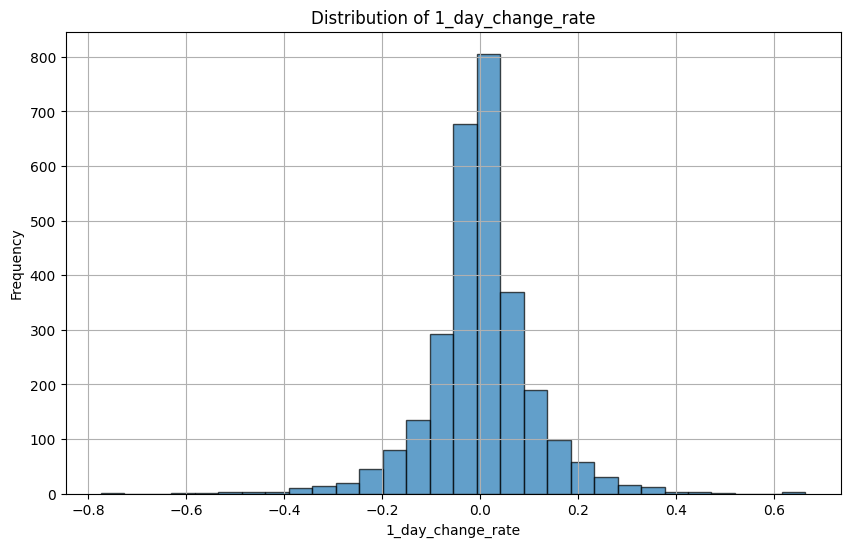

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# 假設 cleaned_df 是你的 DataFrame
# 繪製 1_day_change_rate 的直方圖
plt.figure(figsize=(10, 6))
plt.hist(cleaned_df['1_day_change_rate'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of 1_day_change_rate')
plt.xlabel('1_day_change_rate')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [49]:
threshold = 0.03
count_greater = (cleaned_df['1_day_change_rate'] > threshold).sum()
count_between = ((cleaned_df['1_day_change_rate'] < threshold) & (cleaned_df['1_day_change_rate'] > -threshold)).sum()
count_less = (cleaned_df['1_day_change_rate'] < -threshold).sum()
print('count_greater:', count_greater)
print('count_between:', count_between)
print('count_less:', count_less)

count_greater: 912
count_between: 1075
count_less: 882


In [50]:
import pandas as pd

# 假設 cleaned_df 是你的 DataFrame
threshold = 0.03

# 定義一個函數來分配 three_class_label
def assign_label(value):
    if value > threshold:
        return 1
    elif value < -threshold:
        return -1
    else:
        return 0

# 使用 apply 方法來創建新的欄位
cleaned_df['three_class_label'] = cleaned_df['1_day_change_rate'].apply(assign_label)

# 顯示結果
cleaned_df

,stock_symbol,title,date,1_day_close,paragraphs,0_day_close,1_day_change_rate,1_day_change_binary_label,three_class_label
0,NCNO,nCino (NCNO) Q1 2025 Earnings Call Transcript,2024-05-29,30.110001,d day and thank you for standing by. Welcome t...,30.150000,-0.001327,-1,0
1,OKTA,Okta (OKTA) Q1 2025 Earnings Call Transcript,2024-05-29,88.809998,"i\n\nHi, everyone. Welcome to Okta's first qua...",96.360001,-0.078352,-1,-1
2,SSYS,Stratasys (SSYS) Q1 2024 Earnings Call Transcript,2024-05-29,9.020000,"Greetings, and welcome to the Stratasys first ...",8.820000,0.022676,1,0
3,NVDA,Nvidia (NVDA) Q1 2025 Earnings Call Transcript,2024-05-22,1037.989990,"od afternoon. My name is Regina, and I will be...",949.500000,0.093196,1,1
4,BZUN,Baozun (BZUN) Q1 2024 Earnings Call Transcript,2024-05-28,2.720000,"d morning, ladies and gentlemen, and thank you...",2.660000,0.022556,1,0
...,...,...,...,...,...,...,...,...,...
2864,CNDT,Conduent Incorporated (CNDT) Q4 2021 Earnings ...,2022-02-16,4.680000,\n\nOperator\n\nGreetings. Welcome to the Cond...,4.730000,-0.010571,-1,0
2865,AXTI,AXT (AXTI) Q4 2021 Earnings Call Transcript,2022-02-16,7.610000,"fternoon, everyone, and welcome to AXT's fourt...",7.930000,-0.040353,-1,-1
2866,BCOV,Brightcove (BCOV) Q4 2021 Earnings Call Transc...,2022-02-16,7.780000,tings. Welcome to the Brightcove fourth quarte...,9.040000,-0.139381,-1,-1
2867,APP,AppLovin Corporation (APP) Q4 2021 Earnings Ca...,2022-02-16,64.129997,\nOperator\n\nGreetings. Welcome to AppLovin C...,68.709999,-0.066657,-1,-1


In [51]:
cleaned_df.to_csv('scraping_data/' + formatted_date + '_nasdaq_three_class_label.csv', index=False)